<h1>Modeling and Prediction</h1>
On the West Nile Virus data set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')

In [2]:
#loading cleaned data
X = pd.read_pickle('./data/train.pkl')
y = pd.read_pickle('./data/y.pkl')
#X_test = pd.read_pickle('./data/test.pkl')
#y_test = pd.read_csv('./data/sampleSubmission.csv.zip')

In [3]:
#dropping a few columns I mis-interpreted. Coding sprecies
X = X.drop(['Trap','Sunrise_x','Sunset_x','Sunrise_y','Sunset_y'],axis=1)
#X_test = X_test.drop(['Trap','Sunrise_x','Sunset_x','Sunrise_y','Sunset_y'],axis=1)

#coding species columns
X = pd.get_dummies(X,columns=['Species','month'])
#X_test = pd.get_dummies(X_test,columns=['Species','month'])

In [4]:
# mistakenly, thought that the train_test_split was done for me. It was not, the test set is for the kaggle competition
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

<h2>Random Forest Classifier</h2>
Random Forest Classifier is a great ensemble method which I will look into first with a Random Search CV. The driving metric for analysis is recall. This data set is heavily class biased -- there are few west nile virus sightings compared to the observations as a whole. What's most important is that WNV is not missed, i.e. False Negative. For this purpose, a False Positive is better than False Negative, so recall is the most important metric.

***Building Pipeline***

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from scipy.stats import truncnorm, uniform
from sklearn.impute import SimpleImputer

In [6]:
pipe = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(), 
    RandomForestClassifier()
)

In [7]:
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'randomforestclassifier', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob

In [8]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(2,20)}

rf_rand = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'recall',n_iter=10,
                            random_state = 42)

In [9]:
rf_rand.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='recall')

***Looking at results from the random search***

In [10]:
rf_rand.best_params_

{'randomforestclassifier__n_estimators': 562,
 'randomforestclassifier__max_depth': 13}

In [11]:
rf_res = pd.DataFrame(rf_rand.cv_results_)

In [12]:
rf_res.sort_values('mean_test_score',axis=0, ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,6.676574,0.494606,0.360505,0.108034,562,13,"{'randomforestclassifier__n_estimators': 562, ...",0.071429,0.095238,0.072289,0.036145,0.084337,0.071888,0.019891,1
0,2.309790,0.085612,0.106948,0.008940,245,10,"{'randomforestclassifier__n_estimators': 245, ...",0.047619,0.047619,0.024096,0.012048,0.060241,0.038325,0.017584,2
4,13.082430,0.267924,0.713468,0.101567,1300,10,"{'randomforestclassifier__n_estimators': 1300,...",0.047619,0.047619,0.024096,0.012048,0.060241,0.038325,0.017584,2
6,4.635134,0.134347,0.238203,0.058156,473,10,"{'randomforestclassifier__n_estimators': 473, ...",0.047619,0.035714,0.036145,0.012048,0.048193,0.035944,0.013095,4
2,11.522877,0.030594,0.520742,0.017121,1584,7,"{'randomforestclassifier__n_estimators': 1584,...",0.011905,0.000000,0.012048,0.000000,0.000000,0.004791,0.005867,5
1,3.885598,0.008139,0.230907,0.009363,910,2,"{'randomforestclassifier__n_estimators': 910, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
3,2.922855,0.071087,0.156257,0.021393,465,5,"{'randomforestclassifier__n_estimators': 465, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
7,7.562625,0.090873,0.434218,0.008798,1735,2,"{'randomforestclassifier__n_estimators': 1735,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
8,3.385971,0.098858,0.194454,0.032681,819,2,"{'randomforestclassifier__n_estimators': 819, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6
9,2.118760,0.051734,0.094521,0.008321,533,3,"{'randomforestclassifier__n_estimators': 533, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6


In [13]:
rf_rand.best_score_

0.0718875502008032

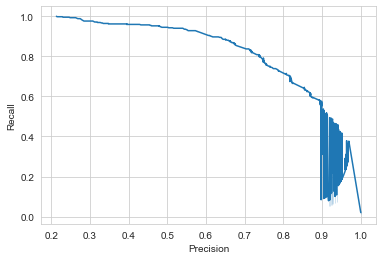

In [14]:
from sklearn.metrics import precision_recall_curve

def pr_curve(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred_rf = e.predict_proba(x)

    #finding curve
    p, r, t = precision_recall_curve(y.to_numpy(),y_pred_rf[:,1])
    sns.lineplot(x=p,y=r)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    return pd.DataFrame({'precision':p[:-1],'recall':r[:-1],'threshold':t})

    
c = pr_curve(rf_rand.best_estimator_,X_train,y_train)

In [15]:
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

,precision,recall,threshold,sum
1053,0.710794,0.83693,0.244112,1.547725


***Comparing to test set***

In [16]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def test_comp(e,t):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    #deciding membership
    y_pred = (y_pred >= t).astype('int')
    
    r = np.round(recall_score(y_test,y_pred),3)
    p = np.round(precision_score(y_test,y_pred),3)
    print('Evaluating the classifier on the test set, the recall is: ' +  
          '{}, and the precision is: {}'.format(r,p))

test_comp(rf_rand.best_estimator_,0.247047)

Evaluating the classifier on the test set, the recall is: 0.261, and the precision is: 0.246


<h3>Random Forest first results</h3>

As I thought, the classifier was overfit. I will re-run with a much lower max depth. 

In [17]:
params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
         'randomforestclassifier__max_depth' :  np.arange(1,5)}

rf_rand = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'recall',n_iter=10,
                            random_state = 42)
rf_rand.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([1, 2, 3, 4]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='recall')

,precision,recall,threshold,sum
0,0.065177,1.0,0.023372,1.065177


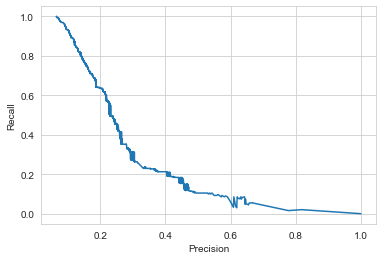

In [18]:
c = pr_curve(rf_rand.best_estimator_,X_train,y_train)
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

In [19]:
c[np.round(c.recall,2) == 0.8].threshold.mean()

0.06377613367189537

In [20]:
rf_rand.best_params_

{'randomforestclassifier__n_estimators': 1470,
 'randomforestclassifier__max_depth': 4}

In [21]:
test_comp(rf_rand.best_estimator_,0.06226)

Evaluating the classifier on the test set, the recall is: 0.724, and the precision is: 0.135


<h3>Random Forest second results</h3>

This classifier generalizes considerably better. The recall is good on the test set and the precision is acceptable.

I will see if with PCA I can improve the results. My intution says that there are too many factors.

<h3>Random Forest with PCA</h3>

In [22]:
from sklearn.decomposition import PCA

In [23]:
pipe_PCA = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    PCA(),
    RandomForestClassifier()
)

In [24]:
params = {'randomforestclassifier__n_estimators': np.arange(200,2000),
         'randomforestclassifier__max_depth' :  np.arange(1,5),
          'pca__n_components' : np.arange(5,75)}

#starting with few iterations, and narrowing the ranges afterwards
rf_rand_PCA = RandomizedSearchCV(pipe_PCA,param_distributions=params,cv=5,n_jobs=-1,
                                 scoring = 'recall',n_iter=10,random_state = 42, verbose =10)

In [25]:
rf_rand_PCA.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.6min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.7min remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'pca__n_components': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74]),
                                        'randomforestclassifier__max_depth': array([1,

In [26]:
rf_rand_PCA.best_params_

{'randomforestclassifier__n_estimators': 1558,
 'randomforestclassifier__max_depth': 4,
 'pca__n_components': 21}

In [27]:
rf_rand_PCA.best_score_

0.007200229489386116

,precision,recall,threshold,sum
1295,0.072075,0.992806,0.031227,1.064881


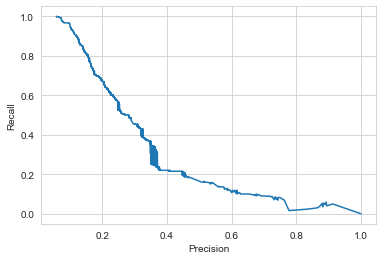

In [28]:
c = pr_curve(rf_rand_PCA.best_estimator_,X_train,y_train)
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

In [29]:
c[np.round(c.recall,2) == 0.8].threshold.mean()

0.05579574895557849

In [30]:
test_comp(rf_rand.best_estimator_,0.056)

Evaluating the classifier on the test set, the recall is: 0.769, and the precision is: 0.121


PCA looks to have little impact on the results of the random forest regressor. Due to the added complexity, I will not use PCA

<h3>Random Forest Conclusions</h3>

On the test test with a 5.6% threshold, 1470 estimators, max depth of 4, the classifier does okay. It yields roughly 76% recall and 12% precision. In more direct terms, roughly 8/10 WNV mosquitos will be correctly predicted as so, while about 1/10 predicted WNV will be accurate. This is over-cautious, appropriate for a public health setting, but with worse precision that I would hope.

<h2>Logistic Regression</h2>
Logistic Regression might be the right classifier for this application. Given that I would like to maximize recall, adjusting the barrier could be a great way to do so. I will take a similar approach of random search over large variety with few iterations, and then narrow down and do more iterations.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
pipe_lr = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

params = {'logisticregression__C': np.logspace(-2,6)}

#starting with few iterations, and narrowing the ranges afterwards
lr = RandomizedSearchCV(pipe_lr,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'recall',n_iter=20,random_state = 42)


In [33]:
lr.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   50.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.9s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logisticregression__C': array([1.00000000e-02, 1.45634848e-02, 2.12095089e-02, 3.08884360e-02,
       4.49843267e-02, 6.55128...
       3.72759372e+02, 5.42867544e+02, 7.90604321e+02, 1.15139540e+03,
       1.67683294e+03, 2.44205309e+03, 3.55648031e+03, 5.17947468e+03,
       7.54312006e+03, 1.09854114e+04, 1.59985872e+04, 2.32995181e+04,
       3.39322177e+04, 4.94171336e+04, 7.19685673e+04, 1.04811313e+05,
       1.52641797e+05, 2.22299648e+05, 3.23745754e+05, 

In [34]:
lr.best_params_

{'logisticregression__C': 23299.51810515367}

In [35]:
lr.best_score_

0.1484848484848485

<h3>Precision Recall Curve - Logistic Regression</h3>


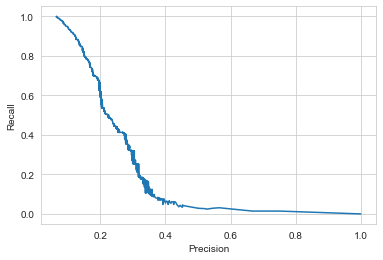

In [36]:
c = pr_curve(lr.best_estimator_,X_train,y_train)

In [37]:
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

,precision,recall,threshold,sum
0,0.065228,1.0,0.000725,1.065228


In [38]:
c[np.round(c.recall,2) == 0.8].threshold.mean()

0.06518273564977835

<h3>Evaluating with test set</h3>

In [39]:
test_comp(lr.best_estimator_,0.0654)

Evaluating the classifier on the test set, the recall is: 0.739, and the precision is: 0.146


<h3>Logistic Regression Conclusions</h3>

The logistic regression results were similar to the random forest results. Both have easy probabilistic interpretations, so I lean more to the random forest classifier, which I'm more comfortable tuning.

<h2>KNN </h2>

I don't expect KNN to give better results due to the high-dimensionality of the feature space. PCA will certainly be necessary here.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    PCA(),
    KNeighborsClassifier(weights='distance')
)

params = {'pca__n_components' : np.arange(10,55),
          'kneighborsclassifier__n_neighbors': np.arange(1,200)}
    

#starting with few iterations, and narrowing the ranges afterwards
knn = RandomizedSearchCV(pipe_knn,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'recall',n_iter=200,random_state = 42)

knn.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'kneighborsclassifier__n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  1...
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199]),
      

In [69]:
knn.best_params_

{'pca__n_components': 51, 'kneighborsclassifier__n_neighbors': 3}

In [70]:
knn.best_score_

0.12231784279977051

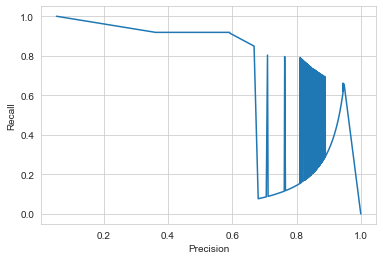

In [71]:
c = pr_curve(knn.best_estimator_,X_train,y_train)

In [72]:
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

,precision,recall,threshold,sum
455,0.945205,0.661871,0.666667,1.607076


In [73]:
c[np.round(c.recall,2) == 0.85].threshold.mean()

0.33333333333333337

<h3>Evaluating with test set</h3>

In [74]:
test_comp(knn.best_estimator_,0.33)

Evaluating the classifier on the test set, the recall is: 0.328, and the precision is: 0.2


<h3>KNN Conclusions</h3>

I could tune KNN's performances on the train set to do quite well -- peaking at 18% recall. The model generalizes poorly, so I will not be using it. 

<h2>SVC</h2>

SVC is supposedly good in high dimension data, and the set I have is relatively high dimension. 

In [77]:
from sklearn.svm import SVC

pipe_svc = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    SVC(probability=True)
)

params = {'svc__C': np.logspace(-5,5)}
    

#starting with few iterations, and narrowing the ranges afterwards
svc = RandomizedSearchCV(pipe_svc,param_distributions=params,cv=5, n_jobs=-1, verbose =10, 
                                 scoring = 'recall',n_iter=10,random_state = 42)

svc.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  2.8min remaining:   36.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.2min remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04...
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04

In [78]:
svc.best_params_

{'svc__C': 62505.51925273976}

In [79]:
svc.best_score_

0.10068846815834767

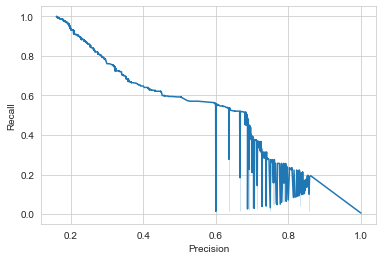

In [80]:
c = pr_curve(svc.best_estimator_,X_train,y_train)

In [81]:
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

,precision,recall,threshold,sum
1541,0.68254,0.515588,0.102623,1.198127


In [82]:
c[np.round(c.recall,2) == 0.85].threshold.mean()

0.10178891962497467

<h3>Evaluating with test set</h3>

In [83]:
test_comp(svc.best_estimator_,0.1)

Evaluating the classifier on the test set, the recall is: 0.56, and the precision is: 0.121


<h3>SVC Conclusions</h3>

Like KNN, SVC performed well on the test set, but generalized quite poorly. It's possible I could tune SVC to be better, but I'm not as familiar with its parameters.

<h1>Choosing a classifier</h1>

Two models stand out as options to ultimately choose -- Random Forest and Logistic Regression. They both generalize faily well, though not to the extent I would hope. Random forest has more hyperparameters that I can tune and evaluate, so I will continue to look into it as the final model.

In [89]:
pipe_rf = make_pipeline( 
    SimpleImputer(strategy='median'),
    StandardScaler(), 
    RandomForestClassifier()
)

params = {'randomforestclassifier__n_estimators': np.arange(50,2000),
          'randomforestclassifier__max_depth' :  np.arange(1,5),
          'randomforestclassifier__min_samples_split' : np.arange(1,5),
          'randomforestclassifier__min_samples_leaf' : np.arange(1,5)}

rf = RandomizedSearchCV(pipe,param_distributions=params,cv=5, n_jobs=-1, scoring = 'recall',n_iter=100,
                            random_state = 42,verbose=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': array([1, 2, 3, 4]),
                                        'randomforestclassifier__min_samples_leaf': array([1, 2, 3, 4]),
                                        'randomforestclassifier__min_samples_split': array([1, 2, 3, 4]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 1997, 1998, 1999])},
                   random_state=42, scoring='recall', verbose=10)

In [91]:
rf.best_params_

{'randomforestclassifier__n_estimators': 1108,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 4}

***Evaluating Performance***

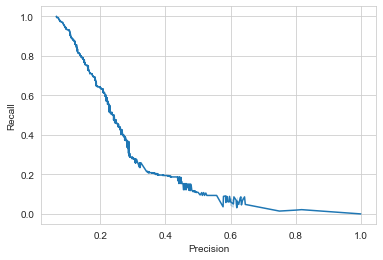

In [92]:
c = pr_curve(rf.best_estimator_,X_train,y_train)

In [94]:
c['sum'] = c['precision'] + c['recall']
c[c['sum'] == c['sum'].max()]

,precision,recall,threshold,sum
0,0.064974,1.0,0.022534,1.064974


In [96]:
c[np.round(c.recall,2) == 0.8].threshold.mean()

0.06309897930530303

In [97]:
test_comp(svc.best_estimator_,0.063)

Evaluating the classifier on the test set, the recall is: 0.881, and the precision is: 0.096


In [103]:
test_comp(svc.best_estimator_,0.09)

Evaluating the classifier on the test set, the recall is: 0.776, and the precision is: 0.12


In [104]:
test_comp(svc.best_estimator_,0.1)

Evaluating the classifier on the test set, the recall is: 0.56, and the precision is: 0.121


In [107]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,rf.best_estimator_.predict(X_train))

0.5

In [109]:
roc_auc_score(y_test,rf.best_estimator_.predict(X_test))

0.5

***Looking at feature importance***

In [125]:
r = rf.best_estimator_
imp = r.steps[2][1].feature_importances_

<AxesSubplot:xlabel='importance', ylabel='feature'>

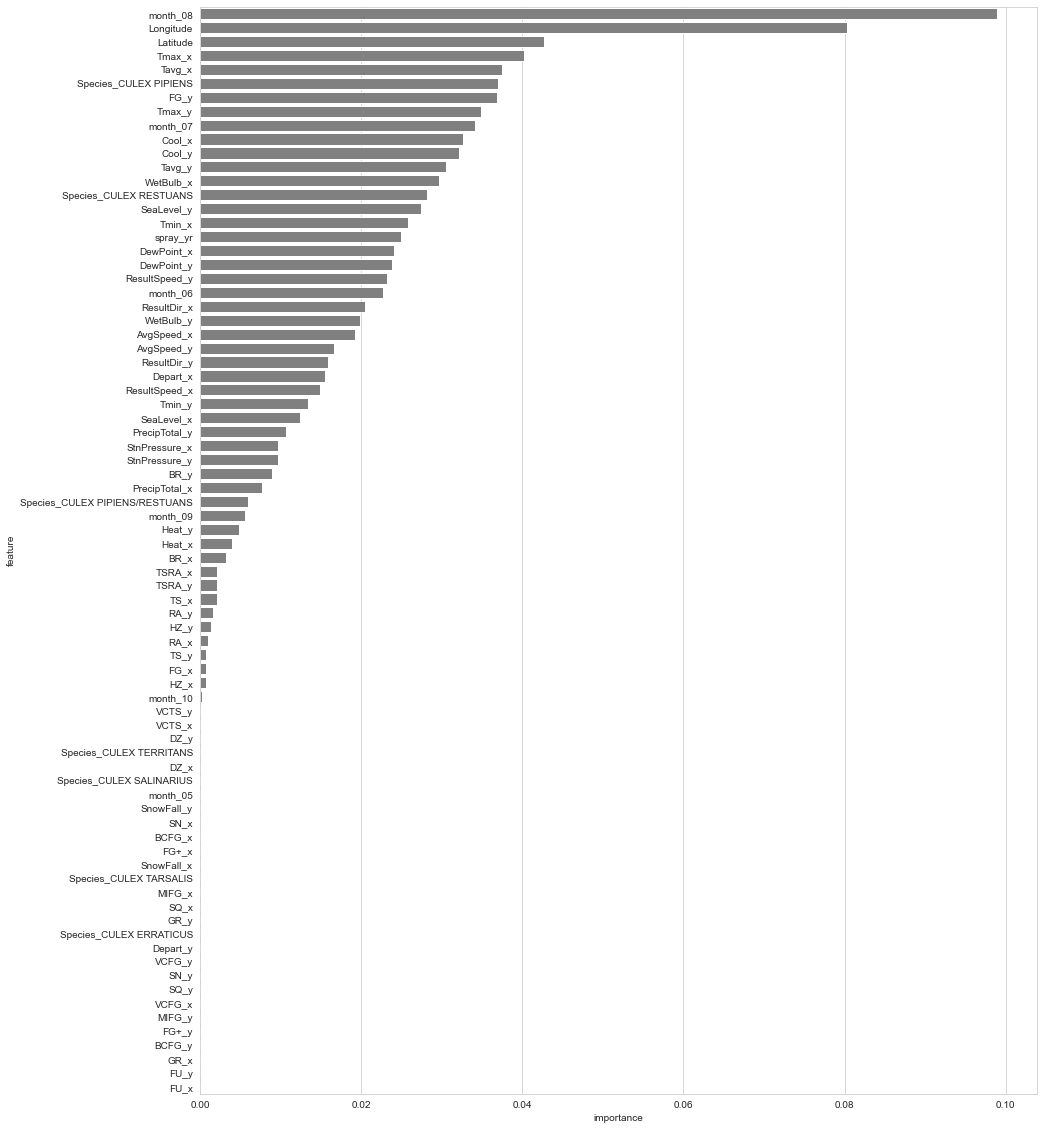

In [137]:
ax = plt.figure(figsize=(15,20))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

<h1>Conclusions</h1>

We are able to predict the appearence of WNV carrying mosquitos in the Chicago area with relative success. With a Random Forest Classifier, we're able to identify more than 80% of the WNV carrying mosquitos based primarily on weather data from two locations in the Chicago area. There is a trade-off however, that only roughly 1/10 positives from the model are true positives. The model gives us a good sense of where WNV is most likely to be, and airs on the side of extreme caution. In order to effectively target mosquito populations, this data set allows prioritization, for treatment or prevention, of zones and weather circumstances that are most closely associated with WNV. 